# Posterior probabilities across models for Insight study (version

x86_64-w64-mingw32, x86_64, mingw32, ucrt, x86_64, mingw32, , 4, 3.2, 2023, 10, 31, 85441, R, R version 4.3.2 (2023-10-31 ucrt), Eye Holes)

John Curtin  
April 4, 2024

### Code Status

In use with iterative improvement.

Updating for use with study-insight

### Notes

Can review online docs for

-   [how to use rstanarm](https://cran.r-project.org/web/packages/rstanarm/vignettes/rstanarm.html)
-   [priors](https://cran.r-project.org/web/packages/rstanarm/vignettes/priors.html)
-   [warnings](https://mc-stan.org/misc/warnings.html)
-   [tutorial on rstanarm and shinystan](https://www.tqmp.org/RegularArticles/vol14-2/p099/p099.pdf)
-   [R Bloggers on perf_mod](https://www.r-bloggers.com/2019/12/tidyposteriors-bayesian-approach-to-model-comparison/)

### Set Up Environment

In [ ]:
study <- "insight"
version <- "v2"

Packages for script

In [ ]:
library(tidyposterior)
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──
✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.6     ✔ workflows    1.1.3
✔ modeldata    1.3.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.3.0
✔ recipes      1.0.9     
── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Use suppressPackageStartupMessages() to eliminate package startup messages

Absolute paths

In [ ]:
switch (Sys.info()[['sysname']],
        # PC paths
        Windows = {
          path_shared <- str_c("P:/studydata/risk/data_processed/shared")
          path_processed <- str_c("P:/studydata/risk/data_processed/", study)
          path_models <- str_c("P:/studydata/risk/models/", study)},
        
        # IOS paths
        Darwin = {
          path_shared <- str_c("P:/studydata/risk/data_processed/shared")
          path_processed <- str_c("/Volumes/private/studydata/risk/data_processed/",
                                  study)
          path_models <- str_c("/Volumes/private/studydata/risk/models/",
                               study)},
        
        # Linux paths
        Linux = {
          path_shared <- str_c("~/mnt/private/studydata/risk/data_processed/shared")
          path_processed <- str_c("~/mnt/private/studydata/risk/data_processed/",
                                  study)
          path_models <- str_c("~/mnt/private/studydata/risk/models/",
                               study)}
)

Chunk Defaults

In [ ]:
knitr::opts_chunk$set(attr.output='style="max-height: 500px;"')

options(tibble.width = Inf)
options(tibble.print_max = Inf)

Source training controls

In [ ]:
# EDA
devtools::source_url("https://github.com/jjcurtin/lab_support/blob/main/fun_eda.R?raw=true")

ℹ SHA-1 hash of file is "c045eee2655a18dc85e715b78182f176327358a7"

### Read in preds and metrics for best model

In [ ]:
auc_1w_all <- read_rds(file.path(path_models, 
                                 str_c("outer_metrics_1week_all_", 
                                       version, "_nested.rds"))) |> 
  arrange(outer_split_num) |> 
  mutate(repeat_num = rep(str_c("repeat", 1:3), each = 10),
         fold_num = rep(str_c("fold", 1:10), 3)) |>   # assumes 3x10 fold
  select(repeat_num, fold_num, roc_auc)

auc_1w_ins <- read_rds(file.path(path_models, 
                                 str_c("outer_metrics_1week_insight_only_", 
                                       version, "_nested.rds"))) |> 
  arrange(outer_split_num) |> 
  mutate(repeat_num = rep(str_c("repeat", 1:3), each = 10),
         fold_num = rep(str_c("fold", 1:10),3)) |>   # assumes 3x10 fold
  select(repeat_num, fold_num, roc_auc)

auc_1w_aase <- read_rds(file.path(path_models, 
                                  str_c("outer_metrics_1week_aase_only_", 
                                        version, "_nested.rds"))) |> 
  arrange(outer_split_num) |> 
  mutate(repeat_num = rep(str_c("repeat", 1:3), each = 10),
         fold_num = rep(str_c("fold", 1:10),3)) |>   # assumes 3x10 fold
  select(repeat_num, fold_num, roc_auc)

auc <- auc_1w_all %>% 
  rename(week_all = roc_auc) %>% 
  mutate(week_ins = auc_1w_ins$roc_auc,
         week_aase = auc_1w_aase$roc_auc) %>% 
  glimpse()

Rows: 30
Columns: 5
$ repeat_num <chr> "repeat1", "repeat1", "repeat1", "repeat1", "repeat1", "rep…
$ fold_num   <chr> "fold1", "fold2", "fold3", "fold4", "fold5", "fold6", "fold…
$ week_all   <dbl> 0.8932005, 0.8348008, 0.8794932, 0.8339037, 0.8352377, 0.89…
$ week_ins   <dbl> 0.7975388, 0.6875551, 0.8691016, 0.6514497, 0.8116925, 0.79…
$ week_aase  <dbl> 0.7859752, 0.4456172, 0.6300183, 0.4173161, 0.5234222, 0.62…

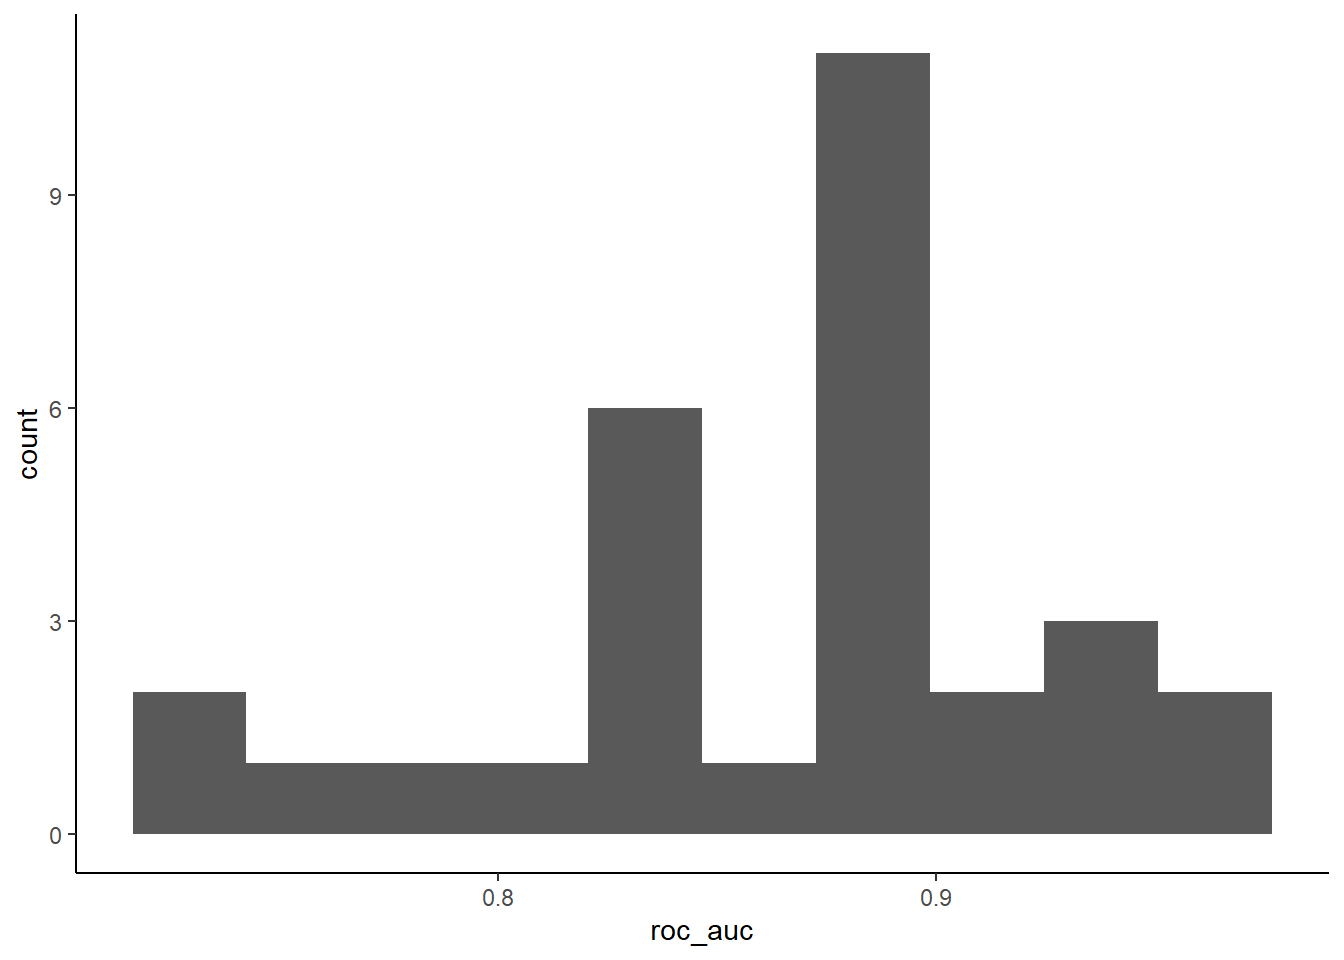

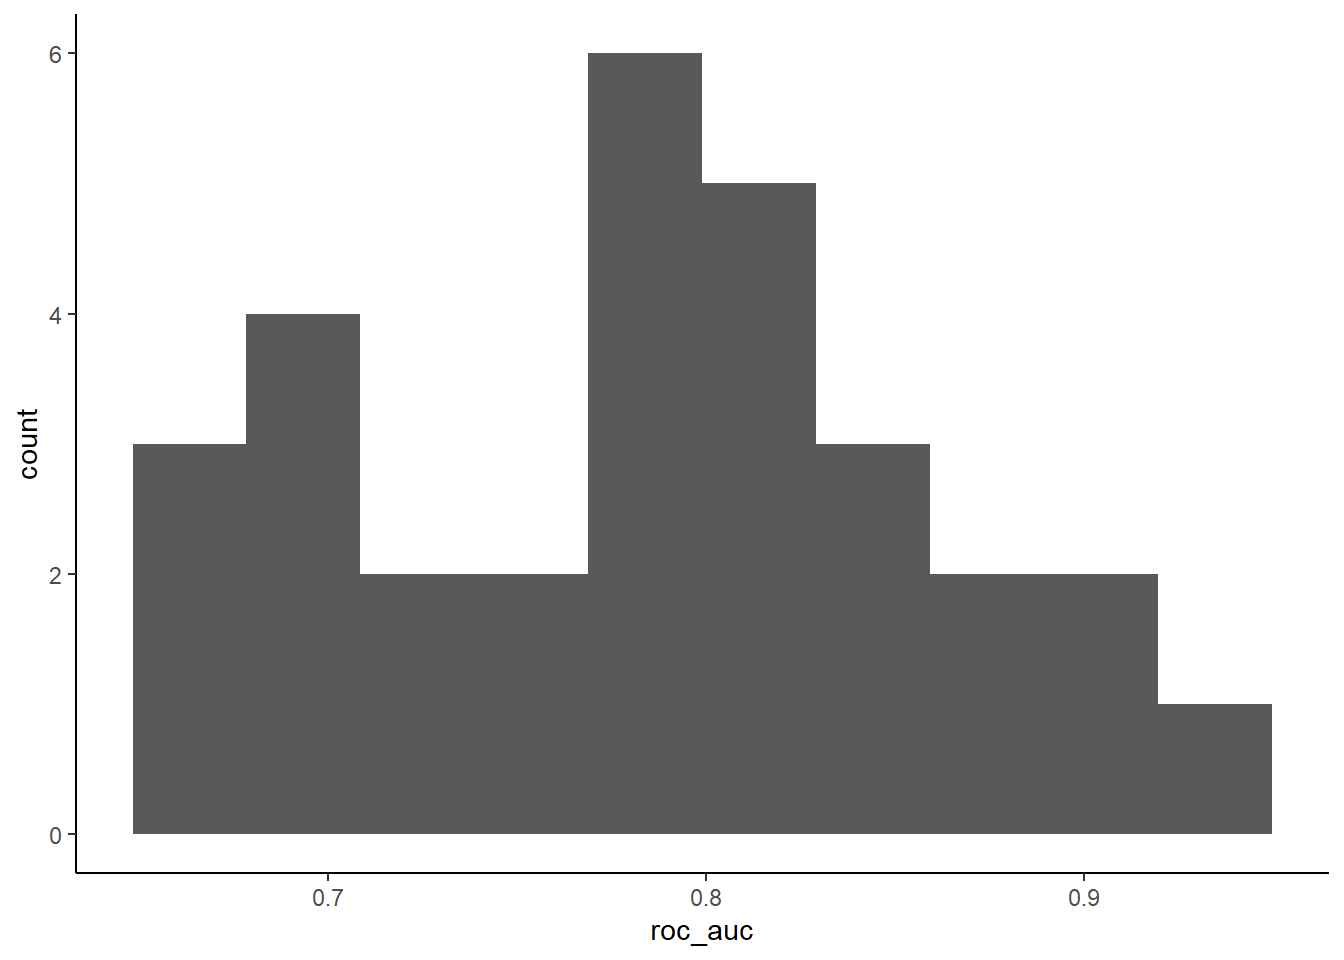

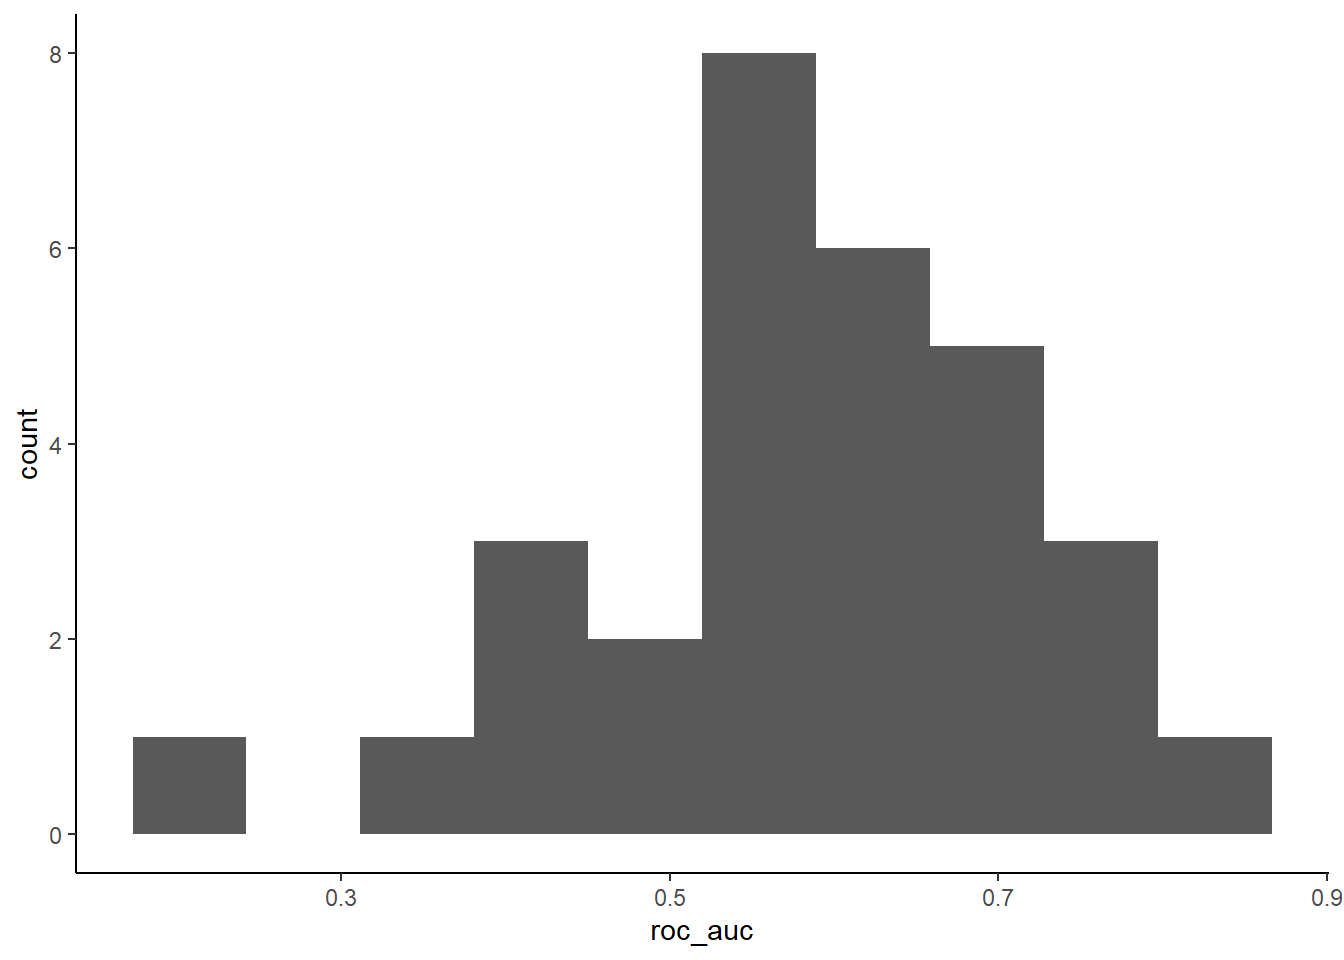

In [ ]:
auc_1w_all %>% 
  ggplot() + 
  geom_histogram(aes(x = roc_auc), bins = 10)

### All models

In [ ]:
# from ?perf_mod()
# Repeated CV (id = repeat, id2 = fold within repeat)
# with a common variance:  statistic ~ model + (model | id2/id)
set.seed(101)
pp <- auc |> 
  rename(id = repeat_num,
         id2 = fold_num) |> 
  perf_mod(formula = statistic ~ model + (1 | id2/id),
           # prior_intercept = rstanarm::student_t(autoscale = TRUE),
           # prior = rstanarm::student_t(autoscale = TRUE),
           transform = tidyposterior::logit_trans,  # for skewed & bounded AUC
           # iter = 2000, chains = 4,  
           adapt_delta = .99,
           # cores = 4, seed = 12345,
           family = gaussian, 
  )  


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 6.7e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.67 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 1.863 seconds (Warm-up)
Chain 1:                1.41 seconds (Sampling)
Chain 1:                3.273

In [ ]:
rstanarm::prior_summary(pp$stan)

Priors for model 'pp$stan' 
------
Intercept (after predictors centered)
  Specified prior:
    ~ normal(location = 1.2, scale = 2.5)
  Adjusted prior:
    ~ normal(location = 1.2, scale = 2.2)

Coefficients
  Specified prior:
    ~ normal(location = [0,0], scale = [2.5,2.5])
  Adjusted prior:
    ~ normal(location = [0,0], scale = [4.54,4.54])

Auxiliary (sigma)
  Specified prior:
    ~ exponential(rate = 1)
  Adjusted prior:
    ~ exponential(rate = 1.2)

Covariance
 ~ decov(reg. = 1, conc. = 1, shape = 1, scale = 1)
------
See help('prior_summary.stanreg') for more details

In [ ]:
summary(pp$stan)


Model Info:
 function:     stan_glmer
 family:       gaussian [identity]
 formula:      statistic ~ model + (1 | id2/id)
 algorithm:    sampling
 sample:       4000 (posterior sample size)
 priors:       see help('prior_summary')
 observations: 90
 groups:       id:id2 (30), id2 (10)

Estimates:
                                        mean   sd   10%   50%   90%
(Intercept)                            0.4    0.1  0.2   0.4   0.5 
modelweek_all                          1.6    0.1  1.5   1.6   1.7 
modelweek_ins                          1.0    0.1  0.9   1.0   1.1 
b[(Intercept) id:id2:repeat1:fold1]    0.2    0.2 -0.1   0.2   0.4 
b[(Intercept) id:id2:repeat1:fold10]  -0.1    0.2 -0.4  -0.1   0.1 
b[(Intercept) id:id2:repeat1:fold2]   -0.1    0.2 -0.4  -0.1   0.1 
b[(Intercept) id:id2:repeat1:fold3]    0.1    0.2 -0.1   0.1   0.4 
b[(Intercept) id:id2:repeat1:fold4]   -0.2    0.2 -0.5  -0.2   0.1 
b[(Intercept) id:id2:repeat1:fold5]   -0.1    0.2 -0.3  -0.1   0.1 
b[(Intercept) id:id2:r

In [ ]:
# shinystan::launch_shinystan(pp$stan)

In [ ]:
pp %>%  write_rds(file.path(path_models, 
                            str_c("posteriors_", version, "_nested.rds")))

### Model posterier CIs

In [ ]:
pp_tidy <- pp %>% 
  tidy(seed = 123)

q = c(.025, .5, .975)
pp_tidy %>% 
  group_by(model) %>% 
  summarize(median = quantile(posterior, probs = q[2]),
            lower = quantile(posterior, probs = q[1]), 
            upper = quantile(posterior, probs = q[3])) %>% 
  mutate(model = factor(model, 
                        levels = c("week_aase", "week_ins", 
                                   "week_all"),
                        labels = c("AASE Static Risk",
                                   "Dynamic Self-Monitoring", 
                                   "Full Features")),
         y = 1000) |> 
  arrange(model)

# A tibble: 3 × 5
  model                   median lower upper     y
  <fct>                    <dbl> <dbl> <dbl> <dbl>
1 AASE Static Risk         0.588 0.524 0.652  1000
2 Dynamic Self-Monitoring  0.795 0.749 0.837  1000
3 Full Features            0.876 0.843 0.902  1000

### Model contrasts

# A tibble: 2 × 9
  contrast              probability    mean  lower   upper  size pract_neg
  <chr>                       <dbl>   <dbl>  <dbl>   <dbl> <dbl>     <dbl>
1 week_ins vs week_aase           1  0.206   0.160  0.254   0.01         0
2 week_ins vs week_all            0 -0.0803 -0.113 -0.0493  0.01         1
  pract_equiv pract_pos
        <dbl>     <dbl>
1           0         1
2           0         0

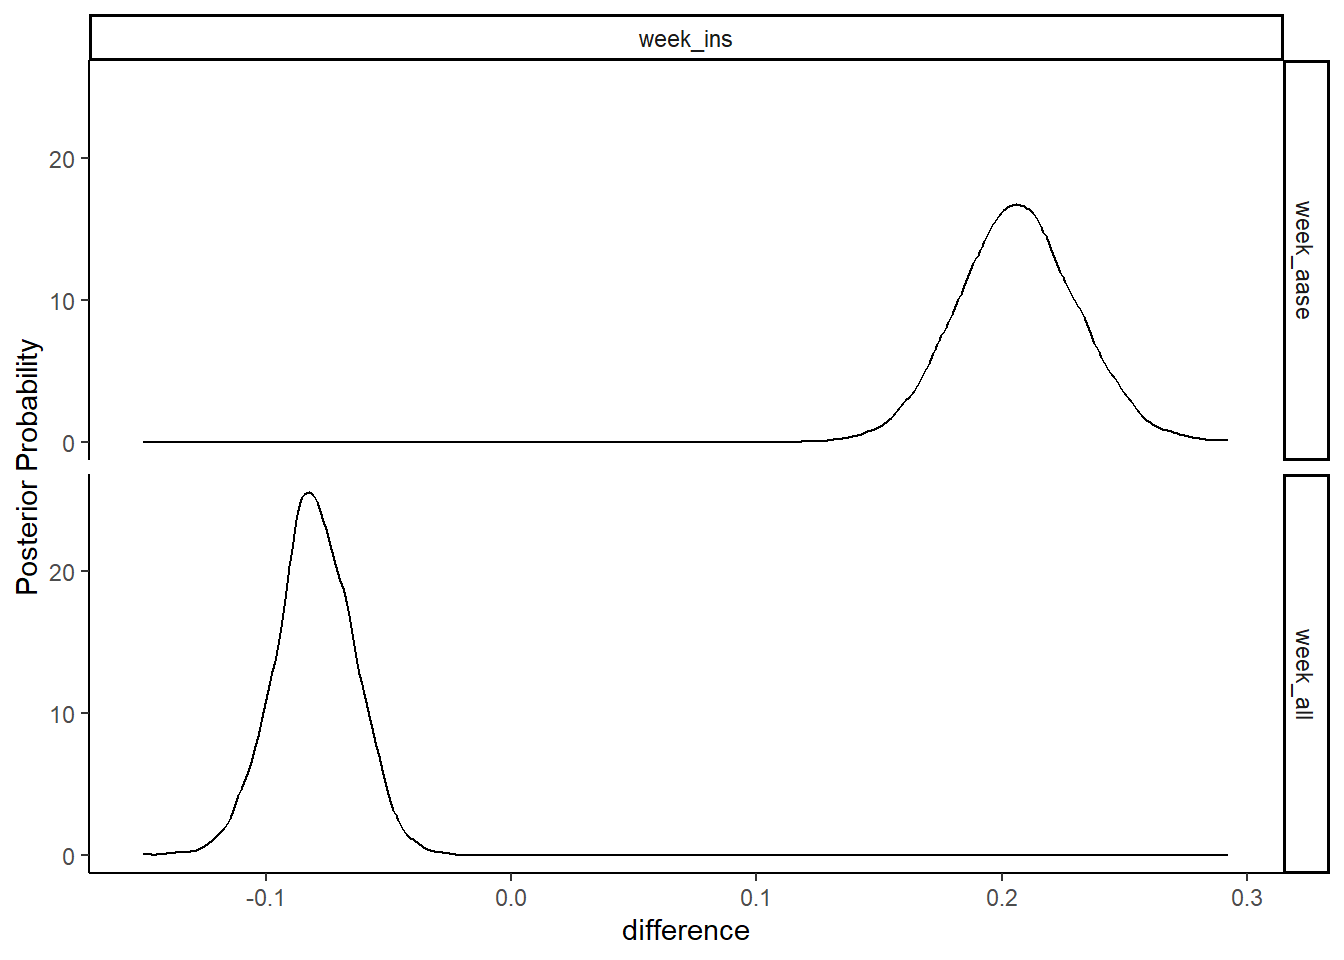

In [ ]:
pp_contrasts <- contrast_models(pp, 
                                list("week_ins", "week_ins"), 
                                list("week_aase", "week_all"))

summary(pp_contrasts, size = 0.01, prob = 0.95)

### Plots

Model posteriors

In [ ]:
ci <- pp_tidy %>% 
  summary() %>% 
  mutate(model = factor(model, 
                        levels = c("week_aase", "week_ins", 
                                   "week_all"),
                        labels = c("AASE Static Risk",
                                   "Dynamic Self-Monitoring", 
                                   "Full Features")),
         y = 1000)

ci_sm <- ci |> 
  filter(model != "Full Features")

ci_ema <- ci |> 
  filter(model != "AASE Static Risk")

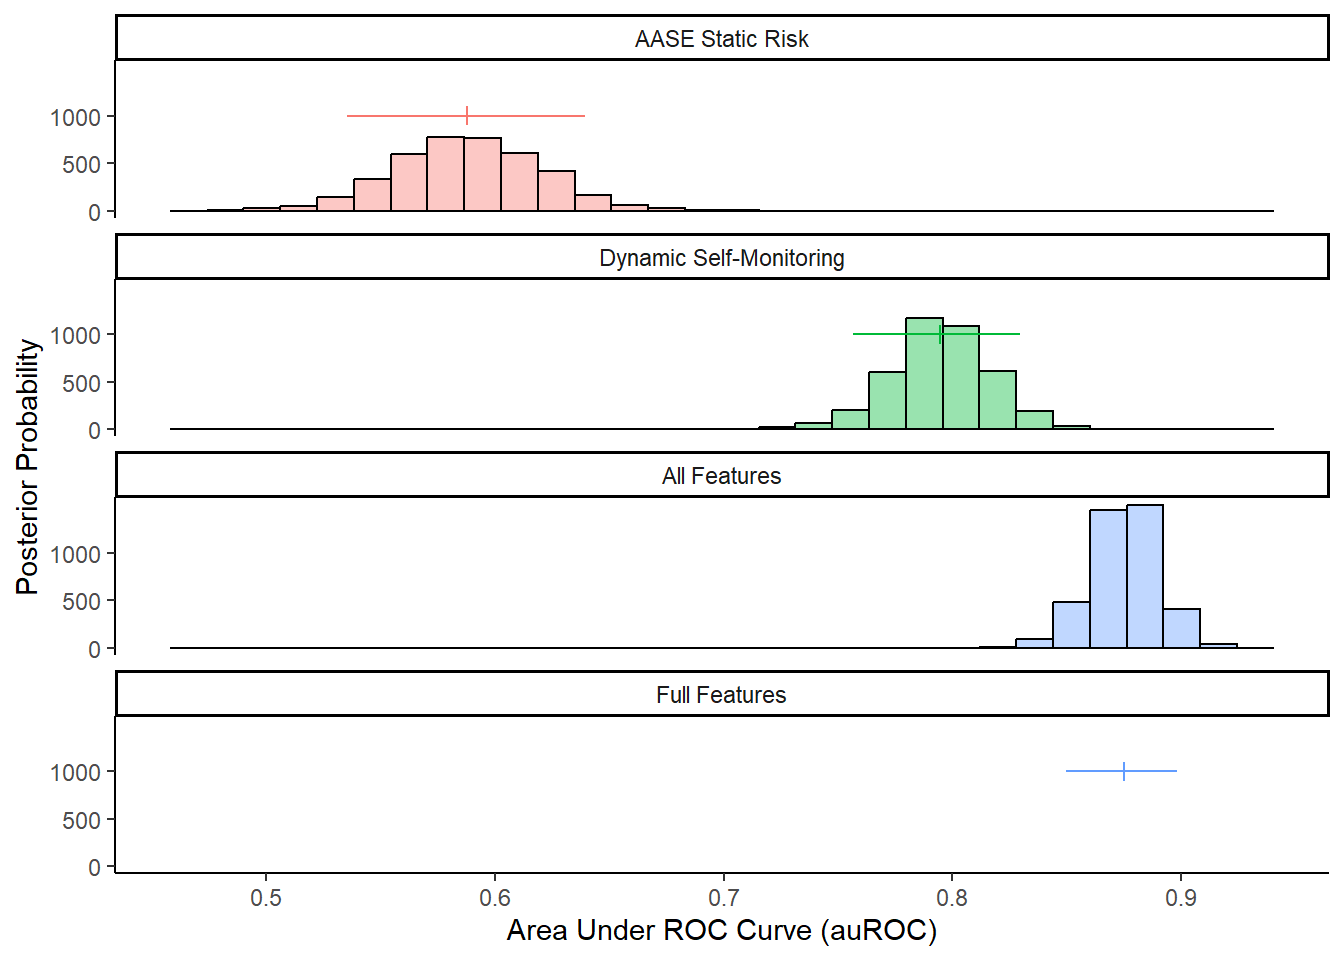

In [ ]:
#| label: fig_post_model_all

pp_tidy %>% 
  mutate(model = factor(model, 
                        levels = c("week_aase", "week_ins", 
                                   "week_all"),
                        labels = c("AASE Static Risk",
                                   "Dynamic Self-Monitoring", 
                                   "All Features")),
         y = 1000) %>%
  ggplot() + 
  geom_histogram(aes(x = posterior, fill = model), 
                 color = "black", alpha = .4, 
                 bins = 30) +
  geom_segment(mapping = aes(y = y+100, yend = y-100, x = mean, xend = mean,
                             color = model),
               data = ci) +
  geom_segment(mapping = aes(y = y, yend = y, x = lower, 
                             xend = upper, color = model),
               data = ci) +
  facet_wrap(vars(model), ncol = 1) +
  scale_y_continuous("Posterior Probability", 
                     breaks = c(0, 500, 1000)) +
  # ylab("Posterior Probability Density") +
  xlab("Area Under ROC Curve (auROC)") +
  labs(color = "Model", fill = "Model") +
  theme(legend.position = "none")

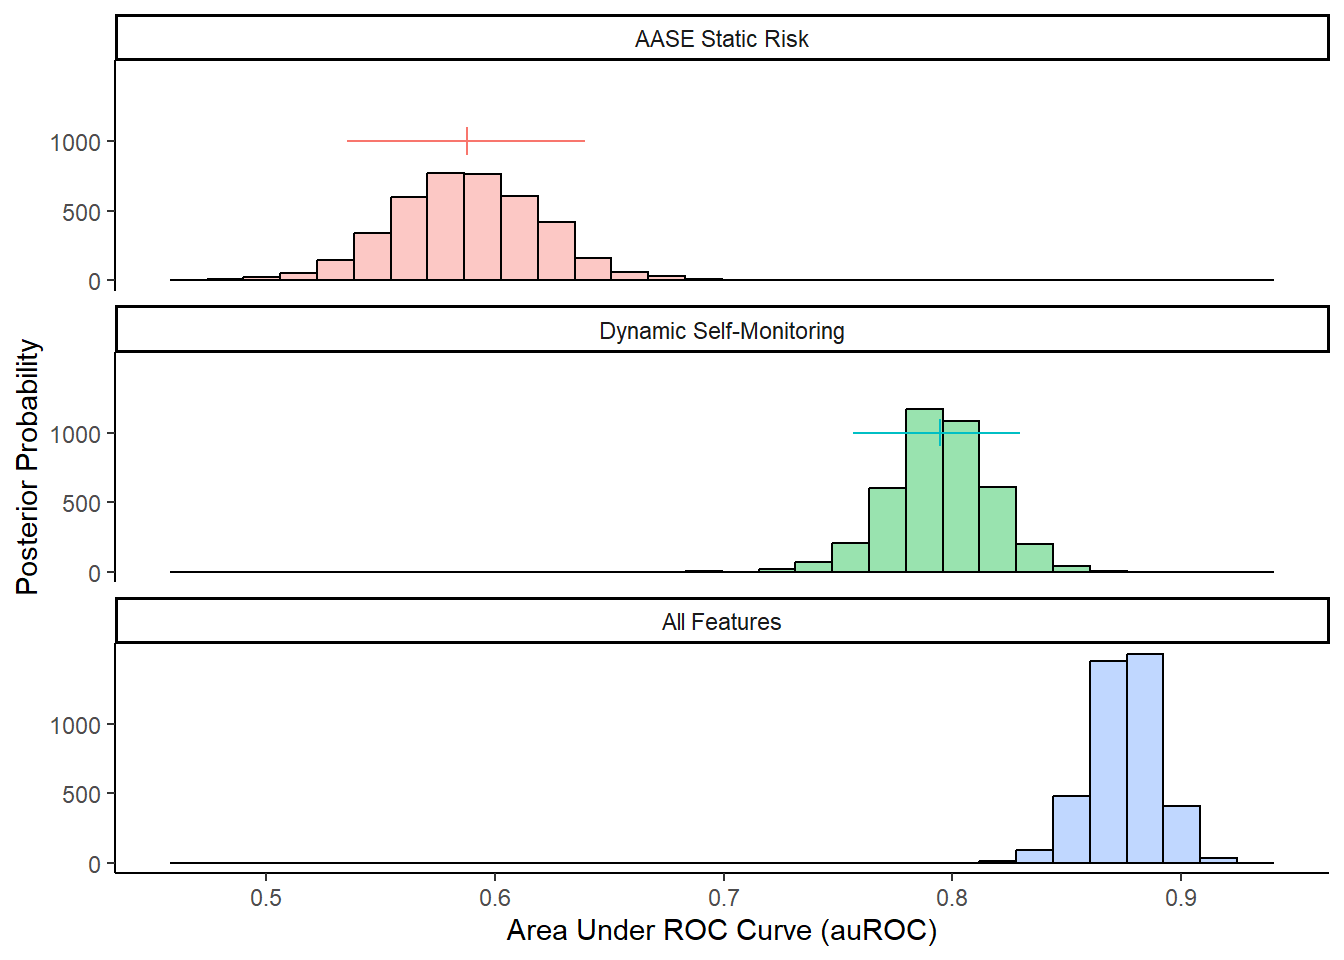

In [ ]:
#| label: fig_post_model_sm

pp_tidy %>% 
  mutate(model = factor(model, 
                        levels = c("week_aase", "week_ins", 
                                   "week_all"),
                        labels = c("AASE Static Risk",
                                   "Dynamic Self-Monitoring", 
                                   "All Features")),
         y = 1000) %>%
  filter(model != "Full Features") |> 
  ggplot() + 
  geom_histogram(aes(x = posterior, fill = model), 
                 color = "black", alpha = .4, 
                 bins = 30) +
  geom_segment(mapping = aes(y = y+100, yend = y-100, x = mean, xend = mean,
                             color = model),
               data = ci_sm) +
  geom_segment(mapping = aes(y = y, yend = y, x = lower, 
                             xend = upper, color = model),
               data = ci_sm) +
  facet_wrap(vars(model), ncol = 1) +
  scale_y_continuous("Posterior Probability", 
                     breaks = c(0, 500, 1000)) +
  # ylab("Posterior Probability Density") +
  xlab("Area Under ROC Curve (auROC)") +
  labs(color = "Model", fill = "Model") +
  theme(legend.position = "none")

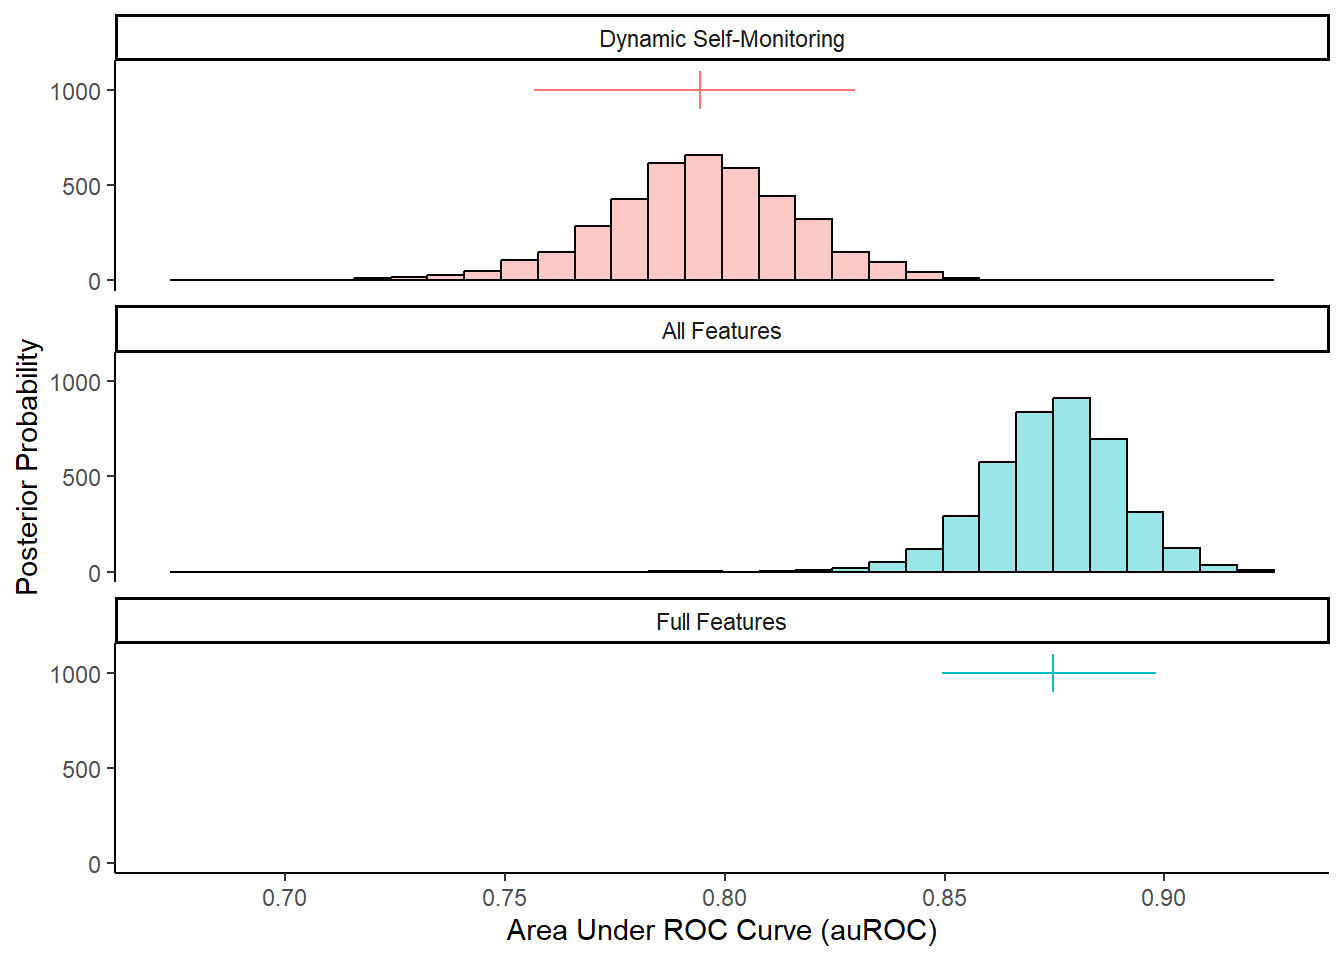

In [ ]:
#| label: fig_post_model_ema

pp_tidy %>% 
  mutate(model = factor(model, 
                        levels = c("week_aase", "week_ins", 
                                   "week_all"),
                        labels = c("AASE Static Risk",
                                   "Dynamic Self-Monitoring", 
                                   "All Features")),
         y = 1000) %>%
  filter(model != "AASE Static Risk") |> 
  ggplot() + 
  geom_histogram(aes(x = posterior, fill = model), 
                 color = "black", alpha = .4, 
                 bins = 30) +
  geom_segment(mapping = aes(y = y+100, yend = y-100, x = mean, xend = mean,
                             color = model),
               data = ci_ema) +
  geom_segment(mapping = aes(y = y, yend = y, x = lower, 
                             xend = upper, color = model),
               data = ci_ema) +
  facet_wrap(vars(model), ncol = 1) +
  scale_y_continuous("Posterior Probability", 
                     breaks = c(0, 500, 1000)) +
  # ylab("Posterior Probability Density") +
  xlab("Area Under ROC Curve (auROC)") +
  labs(color = "Model", fill = "Model") +
  theme(legend.position = "none")

model contrast posteriors

In [ ]:
ci <- pp %>%
  contrast_models(list("week_ins", "week_ins"), 
                  list("week_aase", "week_all")) %>% 
  summary(size = .01) %>% 
  mutate(contrast = factor(contrast, 
                           levels = c("week_ins vs week_aase", 
                                      "week_ins vs week_all"),
                           labels = c("Dynamic vs. Static self-monitoring", 
                                      "Self-monitoring only vs. All Features")),
         y = 700)

ci_sm <- ci |> 
  filter(str_detect(contrast, "Dynamic"))

ci_ema <- ci |> 
  filter(str_detect(contrast, "All")) |> 
  mutate(mean = mean * -1,
         lower = lower * -1,
         upper = upper * -1)

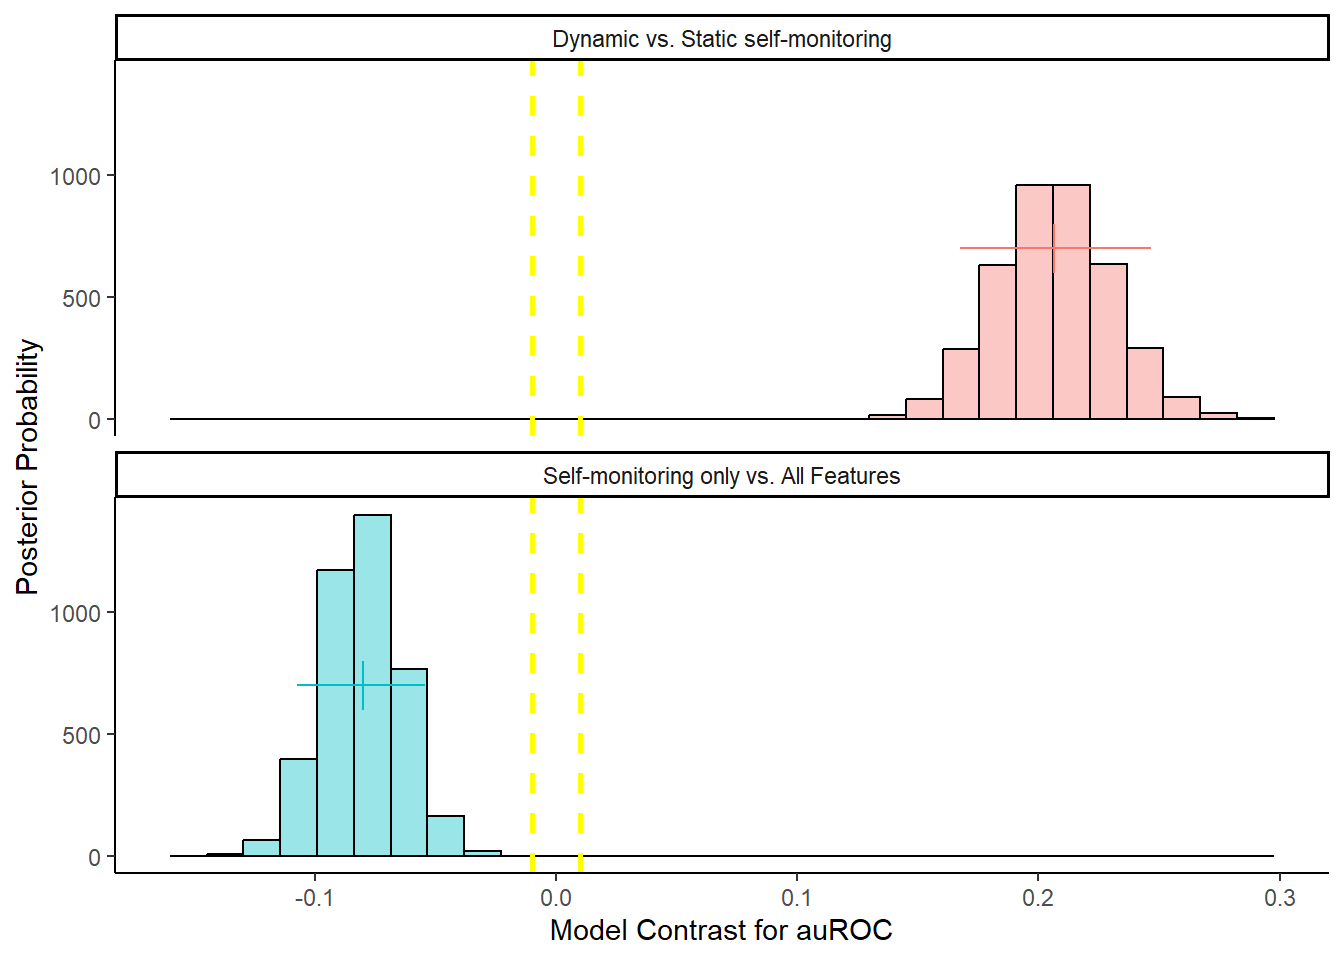

In [ ]:
#| label: fig_post_contrasts_all

pp %>% 
  tidy(seed = 123) %>%   
  group_by(model) %>% 
  mutate(sample = row_number()) %>% 
  ungroup() %>% 
  pivot_wider(names_from = model, values_from = posterior) %>% 
  mutate(ins_vs_aase = week_ins - week_aase,
         ins_vs_all = week_ins - week_all) %>% 
  pivot_longer(cols = ins_vs_aase:ins_vs_all,
               names_to = "contrast",
               values_to = "posterior") %>% 
  mutate(contrast = factor(contrast, 
                           levels = c("ins_vs_aase", 
                                      "ins_vs_all"),
                           labels = c("Dynamic vs. Static self-monitoring", 
                                      "Self-monitoring only vs. All Features"))) %>% 
  ggplot() +
  geom_histogram(aes(x = posterior, fill = contrast), 
                 color = "black", alpha = .4, bins = 30) +
  geom_vline(xintercept = -.01, color = "yellow", 
             linetype = "dashed", linewidth = 1) +
  geom_vline(xintercept = .01, color = "yellow", 
             linetype = "dashed", linewidth = 1) +
  geom_segment(mapping = aes(y = y+100, yend = y-100, x = mean, xend = mean,
                             color = contrast), data = ci) +
  geom_segment(mapping = aes(y = y, yend = y, x = lower, xend = upper, 
                             color = contrast), data = ci) +
  facet_wrap(~contrast, ncol = 1) +
  ylab("Posterior Probability") +
  xlab("Model Contrast for auROC") +
  theme(legend.position = "none")

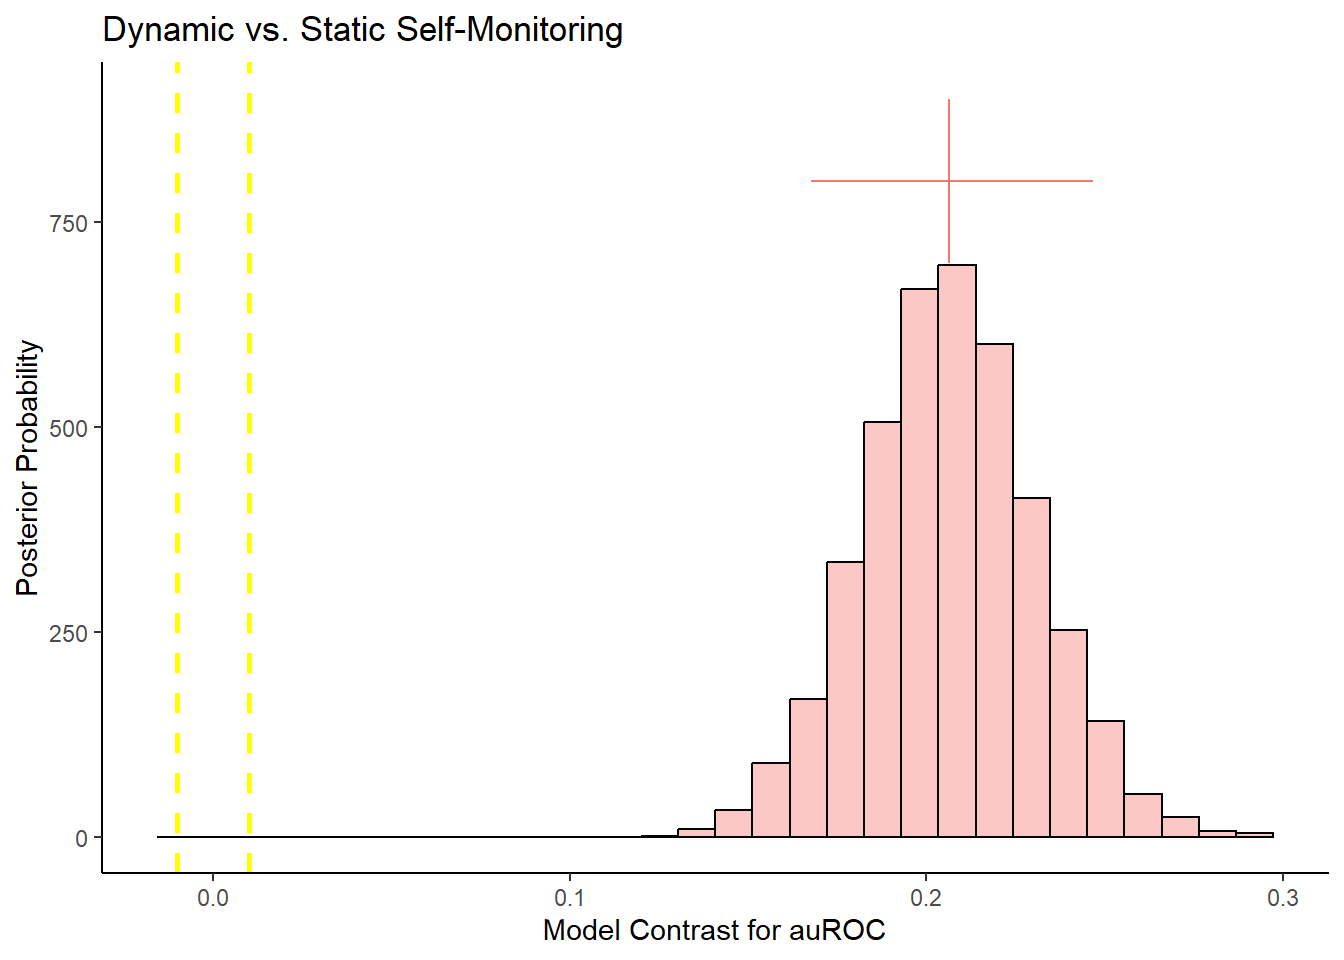

In [ ]:
#| label: fig_post_contrasts_sm

pp %>% 
  tidy(seed = 123) %>%   
  group_by(model) %>% 
  mutate(sample = row_number()) %>% 
  ungroup() %>% 
  pivot_wider(names_from = model, values_from = posterior) %>% 
  mutate(ins_vs_aase = week_ins - week_aase,
         ins_vs_all = week_ins - week_all) %>% 
  pivot_longer(cols = ins_vs_aase:ins_vs_all,
               names_to = "contrast",
               values_to = "posterior") %>% 
  mutate(contrast = factor(contrast, 
                           levels = c("ins_vs_aase", 
                                      "ins_vs_all"),
                           labels = c("Dynamic vs. Static self-monitoring", 
                                      "Self-monitoring only vs. All Features"))) %>% 
  filter(str_detect(contrast, "Dynamic")) |> 
  ggplot() +
  geom_histogram(aes(x = posterior, fill = contrast), 
                 color = "black", alpha = .4, bins = 30) +
  geom_vline(xintercept = -.01, color = "yellow", 
             linetype = "dashed", linewidth = 1) +
  geom_vline(xintercept = .01, color = "yellow", 
             linetype = "dashed", linewidth = 1) +
  geom_segment(mapping = aes(y = y+200, yend = y, x = mean, xend = mean,
                             color = contrast), data = ci_sm) +
  geom_segment(mapping = aes(y = y+100, yend = y+100, x = lower, xend = upper, 
                             color = contrast), data = ci_sm) +
  ylab("Posterior Probability") +
  xlab("Model Contrast for auROC") +
  labs(title = "Dynamic vs. Static Self-Monitoring") +
  theme(legend.position = "none")

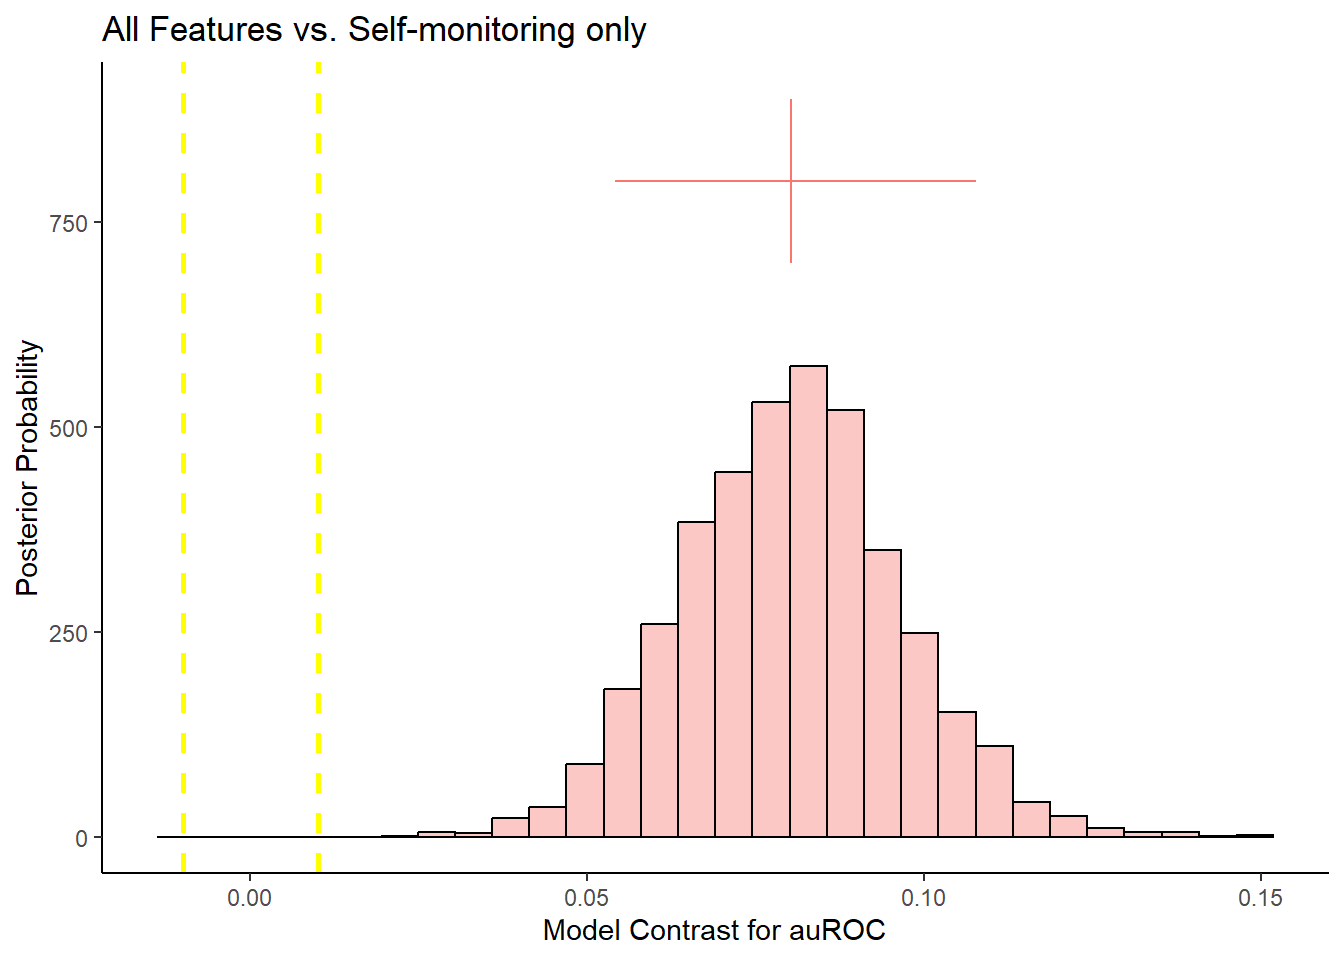

In [ ]:
#| label: fig_post_contrasts_ema

pp %>% 
  tidy(seed = 123) %>%   
  group_by(model) %>% 
  mutate(sample = row_number()) %>% 
  ungroup() %>% 
  pivot_wider(names_from = model, values_from = posterior) %>% 
  mutate(ins_vs_aase = week_ins - week_aase,
         all_vs_ins = week_all - week_ins) %>% 
  pivot_longer(cols = ins_vs_aase:all_vs_ins,
               names_to = "contrast",
               values_to = "posterior") %>% 
  mutate(contrast = factor(contrast, 
                           levels = c("ins_vs_aase", 
                                      "all_vs_ins"),
                           labels = c("Dynamic vs. Static self-monitoring", 
                                      "All Features vs. Self-monitoring only"))) %>% 
  filter(str_detect(contrast, "All")) |> 
  ggplot() +
  geom_histogram(aes(x = posterior, fill = contrast), 
                 color = "black", alpha = .4, bins = 30) +
  geom_vline(xintercept = -.01, color = "yellow", 
             linetype = "dashed", linewidth = 1) +
  geom_vline(xintercept = .01, color = "yellow", 
             linetype = "dashed", linewidth = 1) +
  geom_segment(mapping = aes(y = y+200, yend = y, x = mean, xend = mean,
                             color = contrast), data = ci_ema) +
  geom_segment(mapping = aes(y = y+100, yend = y+100, x = lower, xend = upper, 
                             color = contrast), data = ci_ema) +
  ylab("Posterior Probability") +
  xlab("Model Contrast for auROC") +
  labs(title = "All Features vs. Self-monitoring only") +
  theme(legend.position = "none")